# Combined exposure vs crash risk (Citi Bike + NYPD)

Ziel: Beide Datenquellen gemeinsam nutzen, um die Crash- und Schadensexposition der Citi-Bike-Flotte aus Sicht eines Versicherers zu bewerten.
- Zeitliche Risikosignale (Stunde, Wochentag, Monat) normalisiert auf `crashes per 100k rides`
- Räumliche Hotspots auf grobem Grid (ca. 1 km) mit hoher Crash-Rate pro Fahrt
- Grundlage für Pricing (gefährliche Zeiten/Zonen) und Prävention (Hotspots für Trainings/Hinweise)

Lädt alle Citi-Bike-Fahrten 2023–2025, setzt Schema/Filter, ergänzt Stunde/Wochentag/Monat und berechnet Bounds (min/max Startzeit, Anzahl Fahrten).

In [1]:
# Load Citi Bike rides (2023-2025) and prepare time dimensions
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pl.Config.set_tbl_rows(500)
pl.Config.set_fmt_str_lengths(120)

CITI_DIR = Path("../../raw_data/citi_bike")
CITI_FILES = (
    sorted(CITI_DIR.glob("2023-citibike-tripdata/*.csv"))
    + sorted(CITI_DIR.glob("2024-citibike-tripdata/*.csv"))
    + sorted(CITI_DIR.glob("2025-citibike-tripdata/*.csv"))
)

CITI_SCHEMA = {
    "ride_id": pl.Utf8,
    "rideable_type": pl.Utf8,
    "started_at": pl.Datetime,
    "ended_at": pl.Datetime,
    "start_station_name": pl.Utf8,
    "start_station_id": pl.Int32,
    "end_station_name": pl.Utf8,
    "end_station_id": pl.Int32,
    "start_lat": pl.Float64,
    "start_lng": pl.Float64,
    "end_lat": pl.Float64,
    "end_lng": pl.Float64,
    "member_casual": pl.Utf8,
}

rides_scan = (
    pl.scan_csv([str(p) for p in CITI_FILES], schema=CITI_SCHEMA, try_parse_dates=True, ignore_errors=True)
    .filter(
        pl.col("started_at").is_not_null()
        & pl.col("ended_at").is_not_null()
        & (pl.col("started_at").dt.year() >= 2023)
        & (pl.col("started_at").dt.year() <= 2025)
    )
    .with_columns(
        [
            pl.col("started_at").dt.hour().alias("start_hour"),
            pl.col("started_at").dt.weekday().alias("weekday"),
            pl.col("started_at").dt.strftime("%Y-%m").alias("start_year_month"),
        ]
    )
)

ride_bounds = rides_scan.select(
    pl.col("started_at").min().alias("ride_start_min"),
    pl.col("started_at").max().alias("ride_start_max"),
    pl.len().alias("rides"),
).collect()
ride_bounds

ride_start_min,ride_start_max,rides
datetime[μs],datetime[μs],u32
2023-01-01 00:00:13.021,2025-12-31 23:57:28.999,125181021


Lädt Crash-CSV, harmonisiert Spalten, parst Datum/Zeit, filtert auf Cyclist-Involved im Ride-Zeitraum und berechnet Overview (Zeitraum, Zeilen, Casualties).

In [2]:
DATA_PATH = Path("../../raw_data/nypd/Motor_Vehicle_Collisions_Crashes.csv")
CRASH_SCHEMA = {
    "CRASH DATE": pl.Utf8,
    "CRASH TIME": pl.Utf8,
    "BOROUGH": pl.Utf8,
    "ZIP CODE": pl.Utf8,
    "LATITUDE": pl.Utf8,
    "LONGITUDE": pl.Utf8,
    "LOCATION": pl.Utf8,
    "ON STREET NAME": pl.Utf8,
    "CROSS STREET NAME": pl.Utf8,
    "OFF STREET NAME": pl.Utf8,
    "NUMBER OF PERSONS INJURED": pl.Int64,
    "NUMBER OF PERSONS KILLED": pl.Int64,
    "NUMBER OF PEDESTRIANS INJURED": pl.Int64,
    "NUMBER OF PEDESTRIANS KILLED": pl.Int64,
    "NUMBER OF CYCLIST INJURED": pl.Int64,
    "NUMBER OF CYCLIST KILLED": pl.Int64,
    "NUMBER OF MOTORIST INJURED": pl.Int64,
    "NUMBER OF MOTORIST KILLED": pl.Int64,
    "CONTRIBUTING FACTOR VEHICLE 1": pl.Utf8,
    "CONTRIBUTING FACTOR VEHICLE 2": pl.Utf8,
    "CONTRIBUTING FACTOR VEHICLE 3": pl.Utf8,
    "CONTRIBUTING FACTOR VEHICLE 4": pl.Utf8,
    "CONTRIBUTING FACTOR VEHICLE 5": pl.Utf8,
    "COLLISION_ID": pl.Int64,
    "VEHICLE TYPE CODE 1": pl.Utf8,
    "VEHICLE TYPE CODE 2": pl.Utf8,
    "VEHICLE TYPE CODE 3": pl.Utf8,
    "VEHICLE TYPE CODE 4": pl.Utf8,
    "VEHICLE TYPE CODE 5": pl.Utf8,
}

crash_scan = pl.scan_csv(
    DATA_PATH, schema=CRASH_SCHEMA, infer_schema_length=2000, null_values=[""]
)
rename_map = {name: name.lower().replace(" ", "_") for name in crash_scan.columns}
crash_scan = crash_scan.rename(rename_map).with_columns(
    [
        pl.col("latitude").str.replace(",", ".").cast(pl.Float64, strict=False),
        pl.col("longitude").str.replace(",", ".").cast(pl.Float64, strict=False),
        pl.concat_str([pl.col("crash_date"), pl.col("crash_time")], separator=" ")
        .str.strptime(pl.Datetime, "%m/%d/%Y %H:%M", strict=False)
        .alias("crash_datetime"),
    ]
)

ride_start_min, ride_start_max, ride_rows = ride_bounds.row(0)
crashes = (
    crash_scan.filter(
        pl.col("crash_datetime").is_not_null()
        & (pl.col("crash_datetime") >= ride_start_min)
        & (pl.col("crash_datetime") <= ride_start_max)
        & (
            (pl.col("number_of_cyclist_injured") > 0)
            | (pl.col("number_of_cyclist_killed") > 0)
        )
    )
    .with_columns(
        [
            pl.col("crash_datetime").dt.hour().alias("hour"),
            pl.col("crash_datetime").dt.weekday().alias("weekday"),
            pl.col("crash_datetime").dt.strftime("%Y-%m").alias("year_month"),
            (
                pl.col("number_of_cyclist_injured") + pl.col("number_of_cyclist_killed")
            ).alias("cyclist_casualties"),
        ]
    )
)

crash_overview = crashes.select(
    pl.len().alias("cyclist_crash_rows"),
    pl.sum("cyclist_casualties").alias("cyclist_casualties"),
    pl.col("crash_datetime").min().alias("crash_min"),
    pl.col("crash_datetime").max().alias("crash_max"),
).collect()
crash_overview

/var/folders/3d/gm4l_8mn4_59wxskbwlby73w0000gn/T/ipykernel_18437/2623095685.py:37: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  rename_map = {name: name.lower().replace(" ", "_") for name in crash_scan.columns}


cyclist_crash_rows,cyclist_casualties,crash_min,crash_max
u32,i64,datetime[μs],datetime[μs]
15477,15751,2023-01-01 01:20:00,2025-12-31 20:59:00


Verknüpft Fahrten und Crashes nach Stunde, berechnet Crashes/Casualties pro 100k Fahrten sowie relative Anteile und plottet Exposure vs. Risiko 

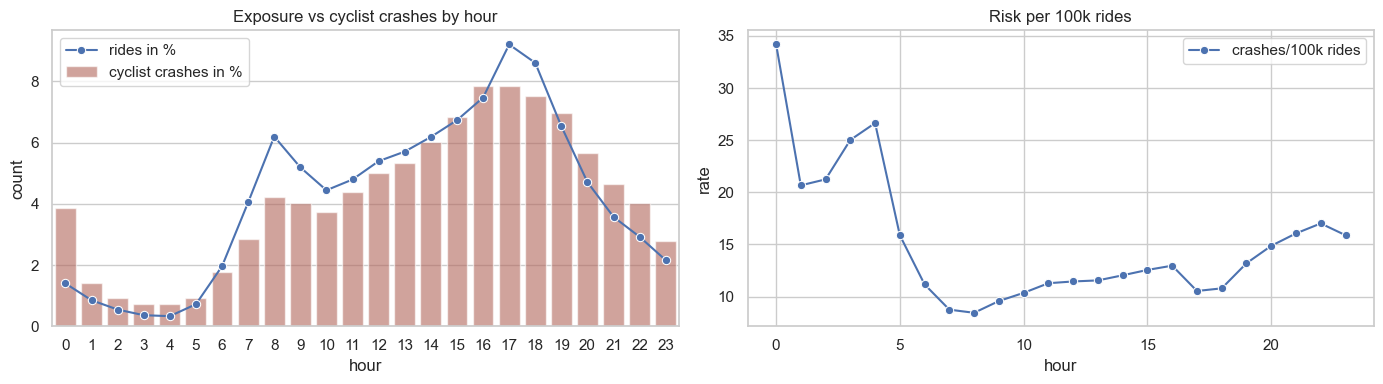

In [3]:
hourly_base = (
    rides_scan.group_by("start_hour")
    .agg(pl.len().alias("rides_count"))
    .join(
        crashes.group_by("hour").agg(
            [
                pl.len().alias("cyclist_crashes_count"),
                pl.sum("cyclist_casualties").alias("cyclist_casualties_count"),
            ]
        ),
        left_on="start_hour",
        right_on="hour",
        how="left",
    )
    .fill_null(0)
    .with_columns(
        [
            (pl.col("cyclist_crashes_count") / pl.col("rides_count") * 1e5).alias("crashes_per_100k_rides"),
            (pl.col("cyclist_casualties_count") / pl.col("rides_count") * 1e5).alias("casualties_per_100k_rides"),
        ]
    )
    .rename({"start_hour": "hour"})
    .sort("hour")
    .collect()
)

rides_total = hourly_base["rides_count"].sum()
crashes_total = hourly_base["cyclist_crashes_count"].sum()
casualties_total = hourly_base["cyclist_casualties_count"].sum()

hourly = hourly_base.with_columns(
    [
        (pl.col("rides_count").cast(pl.Float64) / pl.lit(rides_total) * 100).alias("rides"),
        (pl.col("cyclist_crashes_count").cast(pl.Float64) / pl.lit(crashes_total) * 100).alias("cyclist_crashes"),
        (pl.col("cyclist_casualties_count").cast(pl.Float64) / pl.lit(casualties_total) * 100).alias("cyclist_casualties"),
    ]
)

hourly_pd = hourly.to_pandas()
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=hourly_pd, x="hour", y="rides", marker="o", ax=axes[0], label="rides in %")
sns.barplot(data=hourly_pd, x="hour", y="cyclist_crashes", ax=axes[0], color="#c05b4d", alpha=0.6, label="cyclist crashes in %")
axes[0].set_title("Exposure vs cyclist crashes by hour")
axes[0].set_ylabel("count")
axes[0].legend()

sns.lineplot(data=hourly_pd, x="hour", y="crashes_per_100k_rides", marker="o", ax=axes[1], label="crashes/100k rides")
#sns.lineplot(data=hourly_pd, x="hour", y="casualties_per_100k_rides", marker="o", ax=axes[1], label="casualties/100k rides")
axes[1].set_title("Risk per 100k rides")
axes[1].set_ylabel("rate")
axes[1].legend()
plt.tight_layout()

Berechnet Wochentagsprofil (Crashes/Casualties pro 100k Fahrten) und zeigt Balkendiagramm für casualties per 100k rides je Wochentag.

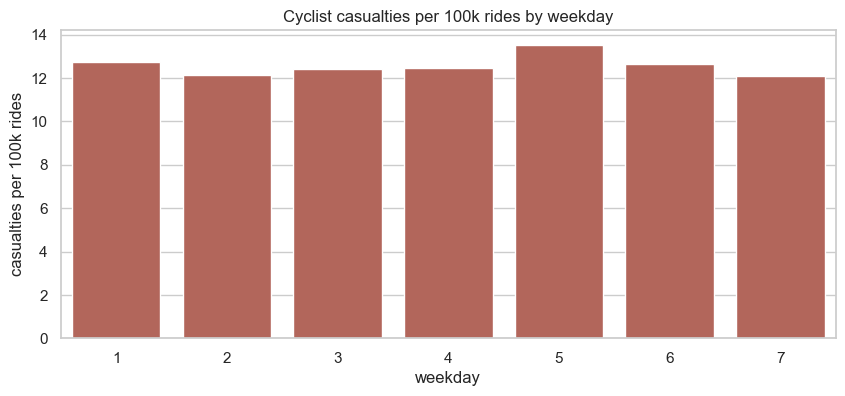

In [ ]:
weekday_names = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}

weekday = (
    rides_scan.group_by("weekday").agg(pl.len().alias("rides"))
    .join(
        crashes.group_by("weekday").agg(
            [
                pl.len().alias("cyclist_crashes"),
                pl.sum("cyclist_casualties").alias("cyclist_casualties"),
            ]
        ),
        on="weekday",
        how="left",
    )
    .with_columns(
        [
            (pl.col("cyclist_crashes") / pl.col("rides") * 1e5).alias("crashes_per_100k_rides"),
            (pl.col("cyclist_casualties") / pl.col("rides") * 1e5).alias("casualties_per_100k_rides"),
        ]
    )
    .sort("weekday")
)

weekday_pd = weekday.collect().to_pandas()
plt.figure(figsize=(10, 4))
sns.barplot(data=weekday_pd, x="weekday", y="casualties_per_100k_rides", color="#c05b4d")
plt.title("Cyclist casualties per 100k rides by weekday")
plt.xlabel("weekday")
plt.ylabel("casualties per 100k rides")
plt.show()

Berechnet Monatsprofil: Anteil Fahrten/Crashes/Casualties je Monat sowie Raten pro 100k Fahrten (Anteile vs. Raten).

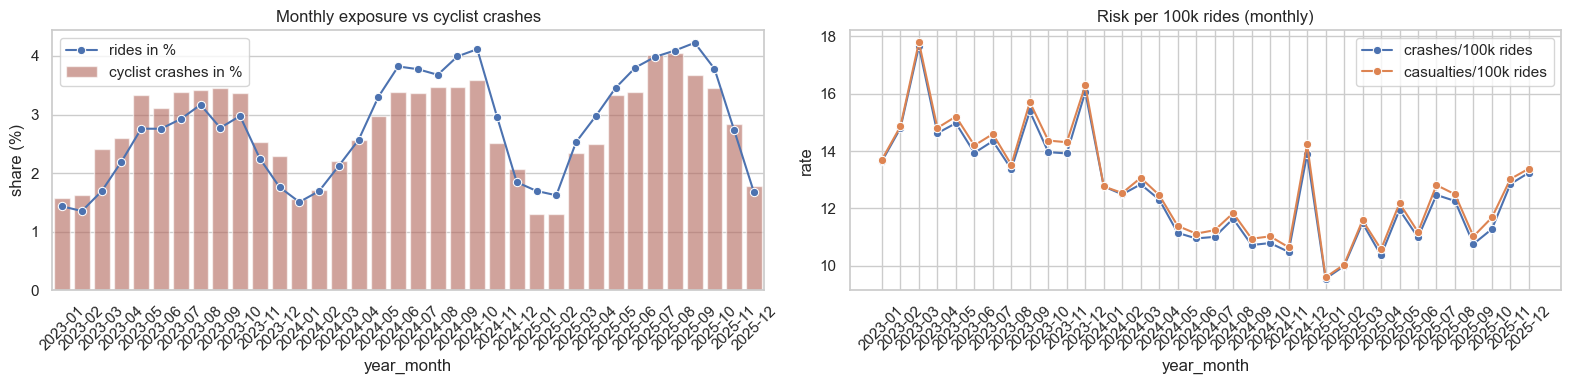

In [9]:
monthly = (
    rides_scan.group_by("start_year_month")
    .agg(pl.len().alias("rides"))
    .join(
        crashes.group_by("year_month").agg(
            [
                pl.len().alias("cyclist_crashes"),
                pl.sum("cyclist_casualties").alias("cyclist_casualties"),
            ]
        ),
        left_on="start_year_month",
        right_on="year_month",
        how="left",
    )
    .with_columns(
        [
            (pl.col("cyclist_crashes") / pl.col("rides") * 1e5).alias("crashes_per_100k_rides"),
            (pl.col("cyclist_casualties") / pl.col("rides") * 1e5).alias("casualties_per_100k_rides"),
        ]
    )
    .rename({"start_year_month": "year_month"})
)

monthly_base = monthly.collect().sort("year_month")

rides_total = monthly_base["rides"].sum()
crashes_total = monthly_base["cyclist_crashes"].sum()
casualties_total = monthly_base["cyclist_casualties"].sum()

monthly_enriched = monthly_base.with_columns(
    [
        (pl.col("rides").cast(pl.Float64) / rides_total * 100).alias("rides_pct"),
        (pl.col("cyclist_crashes").cast(pl.Float64) / crashes_total * 100).alias("cyclist_crashes_pct"),
        (pl.col("cyclist_casualties").cast(pl.Float64) / casualties_total * 100).alias("cyclist_casualties_pct"),
    ]
)

monthly_pd = monthly_enriched.to_pandas()
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

order = monthly_pd["year_month"]

sns.lineplot(data=monthly_pd, x="year_month", y="rides_pct", marker="o", ax=axes[0], label="rides in %")
sns.barplot(data=monthly_pd, x="year_month", y="cyclist_crashes_pct", ax=axes[0], color="#c05b4d", alpha=0.6, label="cyclist crashes in %", order=order)
axes[0].set_title("Monthly exposure vs cyclist crashes")
axes[0].set_ylabel("share (%)")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend()

sns.lineplot(data=monthly_pd, x="year_month", y="crashes_per_100k_rides", marker="o", ax=axes[1], label="crashes/100k rides")
sns.lineplot(data=monthly_pd, x="year_month", y="casualties_per_100k_rides", marker="o", ax=axes[1], label="casualties/100k rides")
axes[1].set_title("Risk per 100k rides (monthly)")
axes[1].set_ylabel("rate")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend()

plt.tight_layout()


Bildet 0.001°-Raster (~100 m), zählt Fahrten/Crashes je Zelle, berechnet Raten pro 100k Fahrten und filtert Hotspots (>=500 Fahrten & Crash>0).

In [10]:
# Spatial hotspots: crashes per 100k rides on clustered grid (round to 0.001 deg ~ 100m)
ride_grid = (
    rides_scan
    .filter(pl.col("start_lat").is_not_null() & pl.col("start_lng").is_not_null())
    .with_columns([
        pl.col("start_lat").round(3).alias("lat_bin"),
        pl.col("start_lng").round(3).alias("lng_bin"),
    ])
    .group_by(["lat_bin", "lng_bin"])
    .agg(pl.len().alias("rides"))
)

crash_grid = (
    crashes
    .filter(pl.col("latitude").is_not_null() & pl.col("longitude").is_not_null())
    .with_columns([
        pl.col("latitude").round(3).alias("lat_bin"),
        pl.col("longitude").round(3).alias("lng_bin"),
    ])
    .group_by(["lat_bin", "lng_bin"])
    .agg(
        [
            pl.len().alias("cyclist_crashes"),
            pl.sum("cyclist_casualties").alias("cyclist_casualties"),
        ]
    )
)

grid_risk = (
    ride_grid.join(crash_grid, on=["lat_bin", "lng_bin"], how="left")
    .fill_null(0)
    .collect()
    .with_columns(
        [
            (pl.col("cyclist_crashes") / pl.col("rides") * 1e5).alias("crashes_per_100k_rides"),
            (pl.col("cyclist_casualties") / pl.col("rides") * 1e5).alias("casualties_per_100k_rides"),
        ]
    )
)

total_rides = grid_risk["rides"].sum()
grid_risk = grid_risk.with_columns((pl.col("rides") / total_rides * 100).alias("ride_share_pct"))

hotspots = (
    grid_risk.filter((pl.col("rides") >= 500) & (pl.col("cyclist_crashes") > 0))
    .sort("casualties_per_100k_rides", descending=True)
)
hotspots.limit(15)

lat_bin,lng_bin,rides,cyclist_crashes,cyclist_casualties,crashes_per_100k_rides,casualties_per_100k_rides,ride_share_pct
f64,f64,u32,u32,i64,f64,f64,f64
40.646,-73.995,526,4,4,760.456274,760.456274,0.00042
40.709,-73.933,902,4,4,443.45898,443.45898,0.000721
40.635,-74.023,538,2,2,371.747212,371.747212,0.00043
40.698,-73.937,1605,5,5,311.52648,311.52648,0.001283
40.641,-73.974,1424,4,4,280.898876,280.898876,0.001138
40.664,-73.957,3765,8,8,212.4834,212.4834,0.003009
40.76,-73.98,1957,4,4,204.394481,204.394481,0.001564
40.753,-73.853,2724,5,5,183.553598,183.553598,0.002177
40.644,-73.989,724,1,1,138.121547,138.121547,0.000579


Erstellt Folium-Karte der Hotspots mit farbcodierter Casualties-Rate und Radius nach Fahrtenzahl; öffnet Browser-Map.

In [ ]:
import folium
from branca.colormap import linear

hotspots_pd = hotspots.sort("casualties_per_100k_rides", descending=True).to_pandas()
color_scale = linear.inferno.scale(
    0,50
)

m = folium.Map(
    location=[hotspots_pd["lat_bin"].mean(), hotspots_pd["lng_bin"].mean()],
    zoom_start=12,
    tiles="cartodbpositron",
)

for _, row in hotspots_pd.iterrows():
    folium.CircleMarker(
        location=(row["lat_bin"], row["lng_bin"]),
        radius=4 + (row["rides"] / hotspots_pd["rides"].max()) * 8,
        color=color_scale(row["casualties_per_100k_rides"]),
        fill=True,
        fill_opacity=0.85,
        tooltip=(
            f"lat={row['lat_bin']:.2f}, lng={row['lng_bin']:.2f}<br>"
            f"rides={row['rides']:,}<br>"
            f"cyclist crashes={row['cyclist_crashes']}<br>"
            f"casualties/100k rides={row['casualties_per_100k_rides']:.1f}"
        ),
    ).add_to(m)

color_scale.caption = "Cyclist casualties per 100k rides"
color_scale.add_to(m)
m.show_in_browser()

Your map should have been opened in your browser automatically.
Press ctrl+c to return.


Hinweis: Die letzten Analysen basieren auf Start/End-Punkten; künftige Route-basierte Analysen wären präziser.

# Die letzten beiden Analysen basieren auf Start- und Endpunkt. Eine bessere Analyse basiert auf den Routen!